<a href="https://colab.research.google.com/github/covidba/covid/blob/master/covid19_jequie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolução da COVID-19 em Jequié/BA
**Fonte**: https://www.instagram.com/prefeiturajequie   
**Dados crus**: https://raw.githubusercontent.com/covidba/covid/master/jequie.csv   
**Github**: https://github.com/covidba/covid

In [2]:
cidade = 'Jequié'
cidade_file_name = 'jequie'
populacao = 155966
 
import sys
from google.colab import drive
drive.mount('/content/gdrive')
 
#!cd gdrive/My\ Drive && git clone https://github.com/ramonfontes/Mathematical-and-Statistical-Modeling-of-COVID19-in-Brazil/ model
!pip install platypus-opt
!pip install pyswarms==1.1.0
 
#add the path were the models are
sys.path.append("/content/gdrive/My Drive/model/main/")

from modelos import SIR

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 71kB 2.9MB/s 
     |████████████████████████████████| 102kB 4.0MB/s 


In [0]:
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import _pickle as pk
import datetime as dt
import pandas as pd
import numpy as np
 
data_atual = date.today().strftime("%d-%m-%Y")
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s.csv' % cidade_file_name
df = pd.read_csv(url, usecols=['data', 'confirmados','recuperados', 'mortes', 'isolamento', 'restricao']) #, parse_dates=['data'])
df.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes', 'Isolamento social (%)', 'Medida restritiva']
df['data'] = pd.to_datetime(df['data'])
ultima_data_valida = df['data'].max().strftime("%d-%m-%Y") # data sem expectativa

In [18]:
#Start the model with population size
model = SIR(tamanhoPop = populacao)
#create a series with the cummulative number of cases
y = df["Casos confirmados"]
#Give the number of days since the day of first case confirmed
x = range(1,len(df["Casos confirmados"]) + 1)

#file1 = open('/content/gdrive/My Drive/model/%s.dat' % cidade_file_name,'rb')
#model = pk.load( file1 )
#file1.close()

model.fit(x = x, y = y)
#model.optimize=None

2020-06-06 22:17:26,624 - pyswarms.single.local_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 1}
pyswarms.single.local_best:   0%|          |0/500/content/gdrive/My Drive/model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))
pyswarms.single.local_best: 100%|██████████|500/500, best_cost=1.71
2020-06-06 22:19:40,984 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 1.713819063741514, best pos: [ 0.23833829  0.16585299  0.21982938 48.0315371 ]


In [19]:
#file1 = open('/content/gdrive/My Drive/model/%s.dat' % cidade_file_name, 'wb')
#pk.dump(model, file1)
#file1.close()

#Predict the number of cases
df["Expectativa"] = model.predict(x)
 
#Projections about the future
futherCases = pd.DataFrame.from_dict({"data":pd.date_range(start = df['data'].max()+timedelta(days=1) , end = df['data'].max()+timedelta(days=14))})
 
df_proj = pd.concat([df,futherCases])
#create the new series to be predicted
predictions = model.predict(df_proj)

/content/gdrive/My Drive/model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))


2020-06-06 22:19:57,995 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


,data,Casos confirmados,Casos recuperados,Mortes,Isolamento social (%),Medida restritiva,Expectativa,Casos ativos,Casos ativos (%)
6,2020-03-29,1,0,0,NaN,NaN,2.792085,1,100.0
7,2020-03-30,1,0,0,NaN,NaN,3.173963,1,100.0
8,2020-03-31,1,0,0,NaN,NaN,3.584577,1,100.0
9,2020-04-01,1,0,0,NaN,NaN,4.026359,1,100.0
10,2020-04-02,1,0,0,NaN,NaN,4.501521,1,100.0
...,...,...,...,...,...,...,...,...,...
71,2020-06-02,423,151,14,NaN,NaN,427.450734,272,64.3
72,2020-06-03,440,157,16,NaN,NaN,452.520165,283,64.3
73,2020-06-04,460,177,17,NaN,NaN,478.958435,283,61.5
74,2020-06-05,486,181,17,NaN,NaN,506.839272,305,62.8


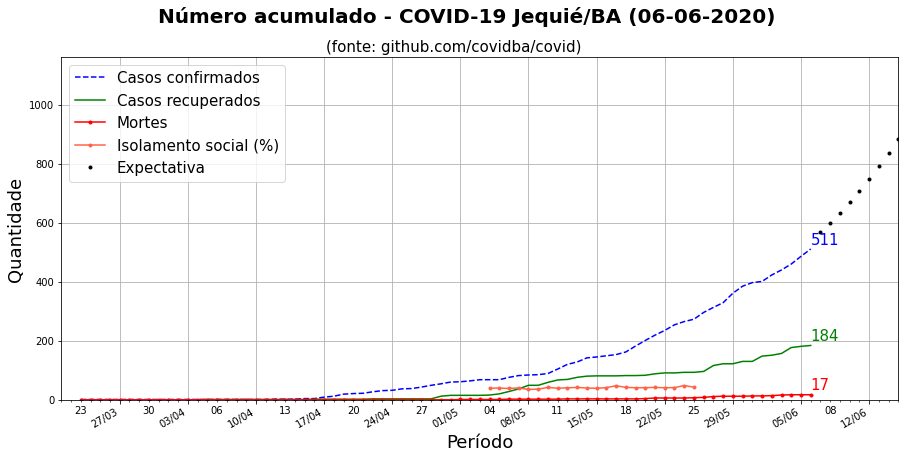

In [20]:
from matplotlib.dates import MO
 
def receber_casos_ativos():
  casos_ativos_diaria = []
  for i, v in enumerate(df['Casos confirmados']):
    casos_ativos_diaria.append(v - df['Casos recuperados'][i])

  percentual_casos_ativos_diaria = []
  for i, v in enumerate(df['Casos confirmados']):
    percentual_casos_ativos_diaria.append('%.1f' % (casos_ativos_diaria[i]*100/v))
  
  return casos_ativos_diaria, percentual_casos_ativos_diaria
 
df['Casos ativos'], df['Casos ativos (%)'] = receber_casos_ativos()

#df['Mortes ocorrência'] = df['Mortes ocorrência'].astype("Float32").astype("Int32")
 
# Remover dias passados da predição
for n in range(len(df['Expectativa'])):
  predictions[n] = np.nan
 
new_df = df.append(futherCases)
new_df.reset_index(inplace=True, drop=True)
new_df['Expectativa'] = predictions

#set date as index
lista_data = new_df['data']
new_df.set_index('data', inplace=True)
 
fig, ax = plt.subplots(figsize=(15,7))
colors = ['b','g','r', 'tomato', 'black']
ls = ['--', '-', '.-', '.-', '.']
 
df2 = new_df
del df2['Casos ativos']
del df2['Medida restritiva']
df2.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()
 
#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime("%d/%m")))
 
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))
 
# ADICIONAR VALORES
casos_confirmados_series = pd.DataFrame(df2['Casos confirmados'])
ultimo_caso_valido_id = casos_confirmados_series.index.get_loc(casos_confirmados_series.last_valid_index())
def adicionar_valores(caso, color, x=0, y=5):
  ax.annotate(int(df2[caso].max()), xy=(lista_data[ultimo_caso_valido_id], df2[caso].max()), 
              xycoords='data', ha='left', fontsize=15, color=color,
              xytext=(x, y), textcoords='offset points')
  
adicionar_valores('Casos confirmados', 'b')
adicionar_valores('Casos recuperados', 'g')
adicionar_valores('Mortes', 'r')
 
casos_ativos = int(df2['Casos confirmados'].max() - df2['Casos recuperados'].max())
#taxa_mortalidade = (100 * df2['Mortes'].max()) / df2['Casos confirmados'].max()
url_fonte = 'github.com/covidba/covid'
 
ax.fill_between(new_df.index, new_df['Casos confirmados'], new_df['Expectativa'], 
                where=new_df['Casos confirmados']>=new_df['Expectativa'], alpha=0.2, color='red')
 
ax.set_ylim(0, new_df['Expectativa'].max())
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()-timedelta(days=5)])
fig.suptitle("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, ultima_data_valida), fontsize=20,  fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Quantidade', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
df.tail(70)

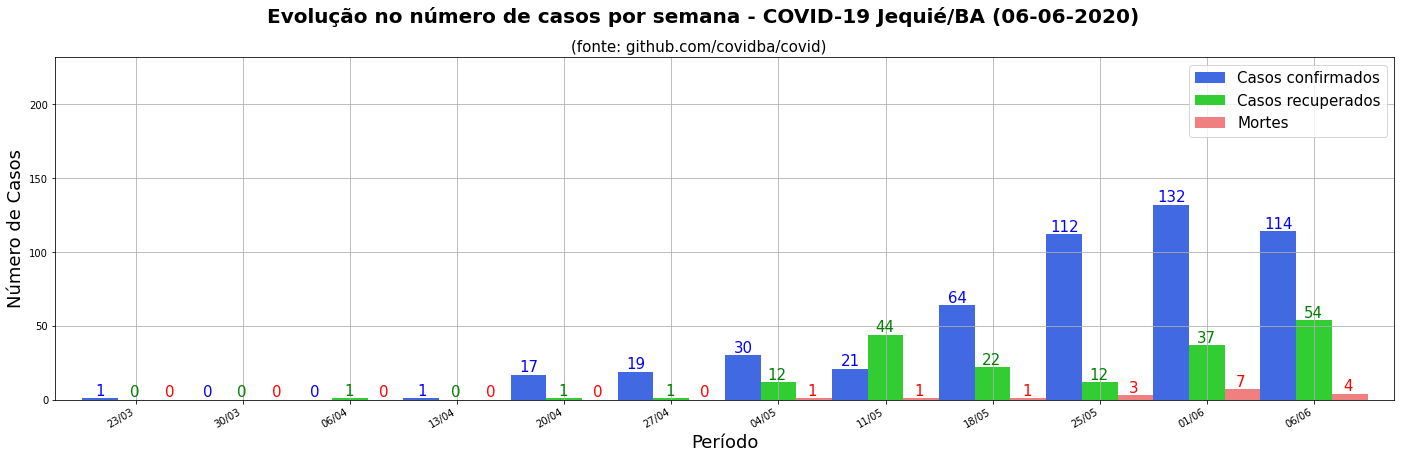

In [21]:
frequencia = 7
colors = ['royalblue','limegreen','lightcoral', 'black']
 
dict_diaria = dict()
dict_diaria['data'] = []
dict_diaria['confirmados_diaria'] = []
dict_diaria['recuperados_diaria'] = []
dict_diaria['mortes_diaria'] = []
 
casos_confirmados_diaria = []
casos_recuperados_diaria = []
casos_mortes_diaria = []
 
def alimentar_lista(lista, texto):
  for id, v in enumerate(new_df[texto]):
    if not pd.isnull(v):
      primeiro_caso_series = pd.DataFrame(df2[texto])
      primeiro_caso_valido_id = primeiro_caso_series.index.get_loc(primeiro_caso_series.first_valid_index())
      if(id) == 0 or id == primeiro_caso_valido_id:
        lista.append(v)  
      else:
        lista.append(v - new_df[texto][id-1])
    elif id < len(lista_data)-14:
      lista.append(0)
 
alimentar_lista(casos_confirmados_diaria, 'Casos confirmados')
alimentar_lista(casos_recuperados_diaria, 'Casos recuperados')
alimentar_lista(casos_mortes_diaria, 'Mortes')
 
def alimentar_dict(lista, texto):
  soma_casos = 0
  for id, v in enumerate(lista):
    if not pd.isnull(v):
      if id % frequencia == 0:
        if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])
        if id == 0:
          dict_diaria[texto].append(v)
        else:
          dict_diaria[texto].append(soma_casos)
          soma_casos = v
      else:
        soma_casos += v     
        if(len(lista)-1 == id):
          dict_diaria[texto].append(soma_casos)
          if texto == 'confirmados_diaria':
            dict_diaria['data'].append(lista_data[id])
 
alimentar_dict(casos_confirmados_diaria, 'confirmados_diaria')
alimentar_dict(casos_recuperados_diaria, 'recuperados_diaria')
alimentar_dict(casos_mortes_diaria, 'mortes_diaria')

df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados', 'Casos recuperados', 'Mortes']
novo_df = df_diaria
 
df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(24,7))
df_diaria.plot(ax=ax, color=colors, kind='bar', width=1)
fig.autofmt_xdate()
 
# workaround para erro em bar kind
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(df_diaria.index.to_series().dt.strftime("%d/%m")))
 
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))
 
def plotar_valores(texto, cor, x):
  for i, v in enumerate(df_diaria[texto]):
    if not pd.isnull(v):
      ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color=cor,
                xytext=(x, 3), textcoords='offset points')
 
plotar_valores('Casos confirmados', 'b', -35)
plotar_valores('Casos recuperados', 'g', -1)
plotar_valores('Mortes', 'r', 34)
#plotar_valores('Casos ativos', 'orange', 26)
 
ax.set_ylim([0, df_diaria['Casos confirmados'].max() + 100])
fig.suptitle("Evolução no número de casos por semana - COVID-19 %s/BA (%s)" % (cidade, ultima_data_valida), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
 
plt.savefig('/content/gdrive/My Drive/model/%s-barras.png' % cidade_file_name)

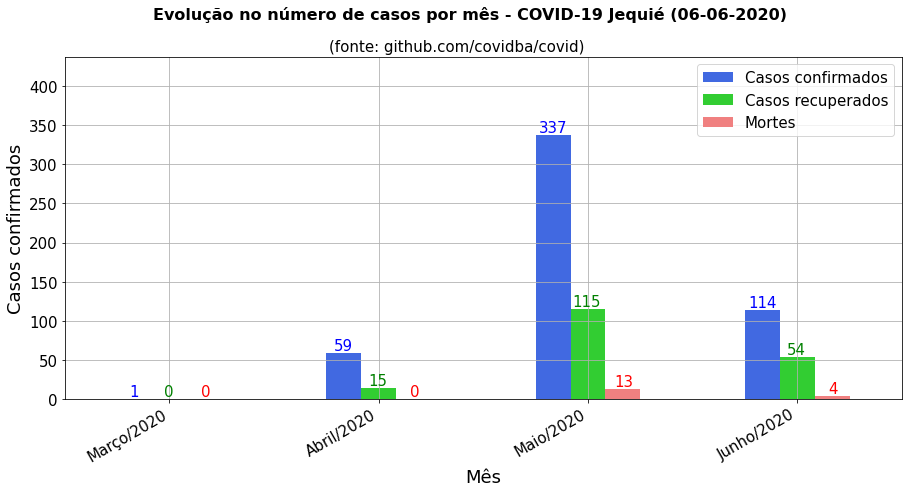

In [22]:
colors = ['royalblue','limegreen','lightcoral', 'orange']
march = pd.date_range(lista_data[0], periods=9) # Março
april = pd.date_range(lista_data[9], periods=30) # Abril
may = pd.date_range(lista_data[39], periods=31) # Maio
june = pd.date_range(lista_data[70], periods=6) # Junho

meses = {'Março': march, 'Abril': april, 'Maio': may, 'Junho': june}
dict_mensal = {'Meses': ['Março/2020', 'Abril/2020', 'Maio/2020', 'Junho/2020']}

dict_mensal['Casos confirmados'] = []
dict_mensal['Casos recuperados'] = []
dict_mensal['Mortes'] = []

def alimentar_meses(texto):
  for id, mes in enumerate(meses.keys()):
    value = new_df.loc[ max(meses[mes]).strftime("%Y-%m-%d") , texto ]
    number = 0 if pd.isnull(value) else value
    dict_mensal[texto].append(number)
    for i in (range(id)):
      if not pd.isnull(dict_mensal[texto][i]):
        dict_mensal[texto][id] -= dict_mensal[texto][i]

alimentar_meses('Casos confirmados')
alimentar_meses('Casos recuperados')
alimentar_meses('Mortes')

pd_mensal = pd.DataFrame(dict_mensal)
pd_mensal.columns = ['Meses', 'Casos confirmados', 'Casos recuperados', 'Mortes'] 

pd_mensal.set_index('Meses', inplace=True)
fig, ax = plt.subplots(figsize=(15,7))
pd_mensal.plot(ax=ax, color=colors, kind='bar', width=.5)
fig.autofmt_xdate()

# workaround para erro em bar kind
#plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(pd_mensal.index.to_series().dt.strftime("%d/%m")))

ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))

def plotar_valores(texto, cor, x):
  for i, v in enumerate(dict_mensal[texto]):
    if not pd.isnull(v):
      ax.annotate(int(v), xy=(i, v), xycoords='data', ha='center', fontsize=15, color=cor,
                xytext=(x, 3), textcoords='offset points')

plotar_valores('Casos confirmados', 'b', -35)
plotar_valores('Casos recuperados', 'g', -1)
plotar_valores('Mortes', 'r', 36)


ax.set_ylim([0, pd_mensal['Casos confirmados'].max() + 100])
fig.suptitle("Evolução no número de casos por mês - COVID-19 %s (%s)" % (cidade, df['data'].max().strftime("%d-%m-%Y")), fontsize=16, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Casos confirmados', fontsize=18)
ax.set_xlabel('Mês', fontsize=18)
ax.grid(True)

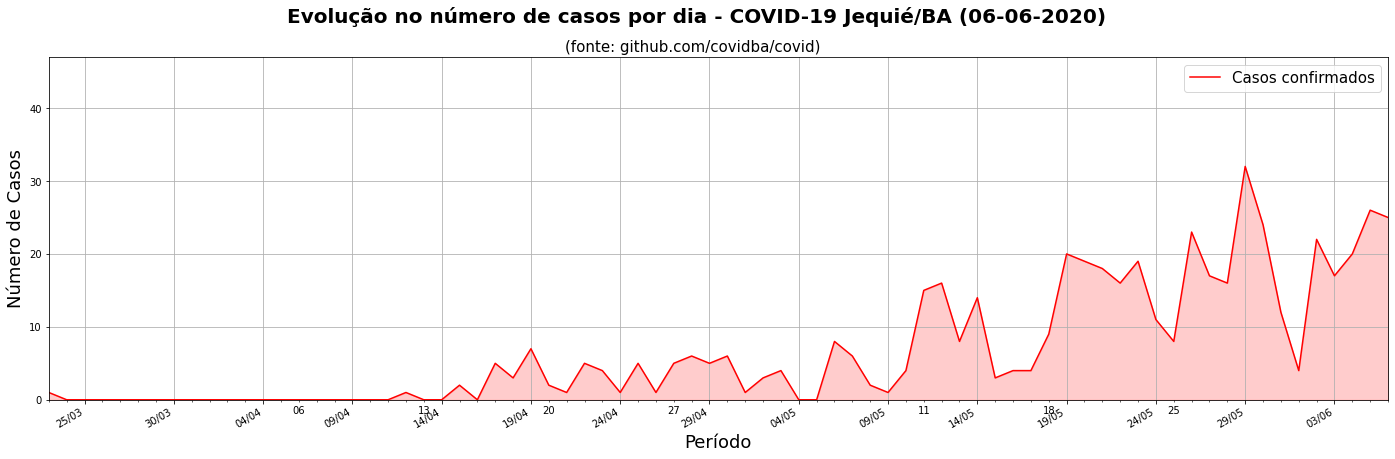

In [23]:
dict_diaria = dict()
dict_diaria['data'] = lista_data[:len(lista_data)-14]
dict_diaria['confirmados_diaria'] = casos_confirmados_diaria
 
df_diaria = pd.DataFrame(dict_diaria)
df_diaria.columns = ['data', 'Casos confirmados']
novo_df = df_diaria
 
df_diaria.set_index('data', inplace=True)
fig, ax = plt.subplots(figsize=(24,7))
df_diaria.plot(ax=ax, color='red', kind='line')
fig.autofmt_xdate()
 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
 
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))
 
ax.fill_between(df_diaria.index, 0, df_diaria['Casos confirmados'], alpha=0.2, color='red')
 
ax.set_ylim([0, df_diaria['Casos confirmados'].max()+15])
ax.set_xlim([lista_data.min(), lista_data.max()-timedelta(days=14)])
fig.suptitle("Evolução no número de casos por dia - COVID-19 %s/BA (%s)" % (cidade, ultima_data_valida), fontsize=20, fontweight='bold')
ax.set_title("(fonte: %s)           " % url_fonte, fontsize=15)
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
#ax.set_yscale('log')
ax.grid(True)
 
plt.savefig('/content/gdrive/My Drive/model/%s-evolucao-diaria.png' % cidade_file_name)

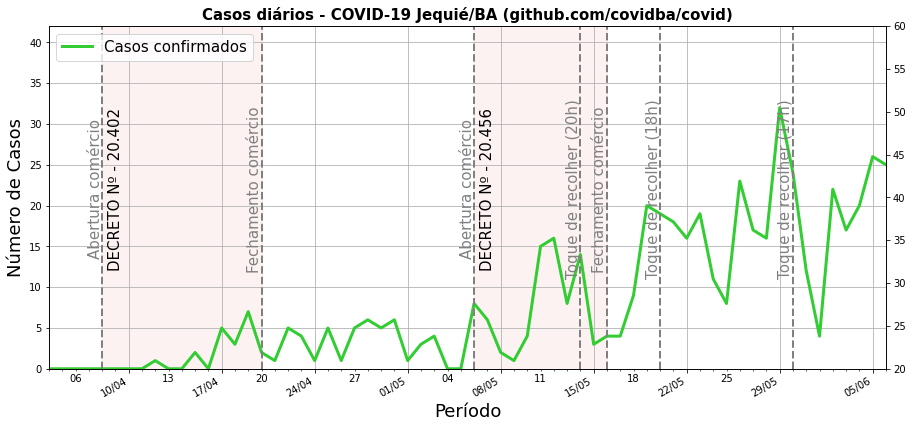

In [24]:
fig, ax = plt.subplots(figsize=(15,7))
ax1 = ax.twinx()
colors = ['limegreen', 'lightcoral']
ls = ['-', '-']

taxa_dict = {'Data': df['data'], 
             'Casos confirmados': casos_confirmados_diaria
             }

#taxa_dict1 = {'Data': df['data'], 
#             'Taxa de isolamento': df['Isolamento social (%)']
#             }

df_taxa = pd.DataFrame(taxa_dict)
df_taxa.columns = ['Data', 'Casos confirmados']
df_taxa.set_index('Data', inplace=True)

#df_taxa1 = pd.DataFrame(taxa_dict1)
#df_taxa1.columns = ['Data', 'Isolamento social (%)']
#df_taxa1.set_index('Data', inplace=True)

df_taxa.plot(ax=ax, color=colors, style=ls, lw=3)
#df_taxa1.plot(ax=ax1, color='dodgerblue', style=ls, lw=3)
fig.autofmt_xdate()
 
#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
 
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15), loc=2)
#ax1.legend(prop=dict(size=15), loc=1)

def adicionar_medida(texto, id, color='gray'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()])
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], (max(casos_confirmados_diaria)-10)), rotation=90,
            xycoords='data', va='center', ha='center', fontsize=15, color=color,
            xytext=(-7, 0), textcoords='offset points')

# ADICIONAR MEDIDAS
def adicionar_medidas():
  for id, medida in enumerate(df['Medida restritiva']):
    if df['data'][id] > lista_data.min() + timedelta(days=1):
      # toque de recolher
      if not pd.isnull(medida):
        if medida == 0:
          adicionar_medida('Abertura comércio', id) 
        elif medida == 1:
          adicionar_medida('Fechamento comércio', id) 
        elif medida > 1 and medida <= 24:
          if medida == 24:
            adicionar_medida('Saída do toque de recolher', id)
          else:
            adicionar_medida('Toque de recolher (%sh)' % int(medida), id)      
        elif medida == 50:
          adicionar_medida('Entrada no lockdown', id)
        elif medida == 51:
          adicionar_medida('Saída do lockdown', id)
        elif medida == 61:
          adicionar_medida('Fase 1 - abertura comércio', id)
        elif medida == 62:
          adicionar_medida('Fase 2 - abertura comércio', id)
        elif medida == 63:
          adicionar_medida('Fase 3 - abertura comércio', id)
        elif medida == 64:
          adicionar_medida('Fase 4 - abertura comércio', id)
        elif medida == 65:
          adicionar_medida('Fase 5 - abertura comércio', id)
  
adicionar_medidas()

ax.axvspan(pd.Timestamp("2020-04-08"), pd.Timestamp("2020-04-20"), alpha=0.1, color='lightcoral')
ax.annotate('DECRETO Nº - 20.402', xy=(pd.Timestamp("2020-04-09"), 32), rotation=90,
            xycoords='data', va='top', ha='center', fontsize=15, color='black',
            xytext=(0, 0), textcoords='offset points')

ax.axvspan(pd.Timestamp("2020-05-06"), pd.Timestamp("2020-05-16"), alpha=0.1, color='lightcoral')
ax.annotate('DECRETO Nº - 20.456', xy=(pd.Timestamp("2020-05-07"), 32), rotation=90,
            xycoords='data', va='top', ha='center', fontsize=15, color='black',
            xytext=(0, 0), textcoords='offset points')
 
# ADICIONAR VALORES  
#adicionar_valores('Casos confirmados', 'g', x=5)
ax.set_xlim([lista_data.min() + timedelta(days=12), df['data'].max()])
ax.set_ylim([0, max(casos_confirmados_diaria)+10])
ax1.set_ylim([20, 60])
ax.set_title("Casos diários - COVID-19 %s/BA (%s)"  % (cidade, url_fonte), fontsize=15, fontweight='bold')
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/%s-isolamento.png' % cidade_file_name)

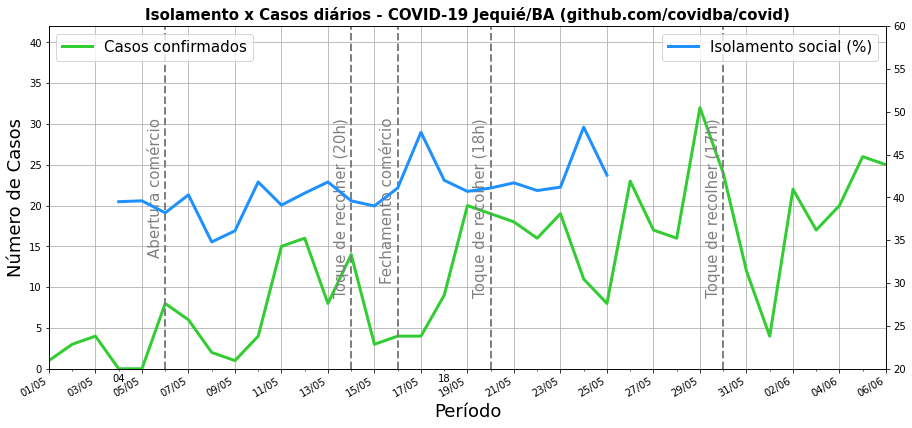

In [25]:
fig, ax = plt.subplots(figsize=(15,7))
ax1 = ax.twinx()
colors = ['limegreen', 'lightcoral']
ls = ['-', '-']

taxa_dict = {'Data': df['data'], 
             'Casos confirmados': casos_confirmados_diaria
             }

taxa_dict1 = {'Data': df['data'], 
             'Taxa de isolamento': df['Isolamento social (%)']
             }

df_taxa = pd.DataFrame(taxa_dict)
df_taxa.columns = ['Data', 'Casos confirmados']
df_taxa.set_index('Data', inplace=True)

df_taxa1 = pd.DataFrame(taxa_dict1)
df_taxa1.columns = ['Data', 'Isolamento social (%)']
df_taxa1.set_index('Data', inplace=True)

df_taxa.plot(ax=ax, color=colors, style=ls, lw=3)
df_taxa1.plot(ax=ax1, color='dodgerblue', style=ls, lw=3)
fig.autofmt_xdate()
 
#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
 
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15), loc=2)
ax1.legend(prop=dict(size=15), loc=1)

def adicionar_medida(texto, id, color='gray'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()])
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], max(casos_confirmados_diaria)), rotation=90,
            xycoords='data', va='top', ha='center', fontsize=15, color=color,
            xytext=(-10, -10), textcoords='offset points')

# ADICIONAR MEDIDAS
def adicionar_medidas():
  for id, medida in enumerate(df['Medida restritiva']):
    if df['data'][id] > lista_data.max() - timedelta(days=50):
      # toque de recolher
      if not pd.isnull(medida):
        if medida == 0:
          adicionar_medida('Abertura comércio', id) 
        elif medida == 1:
          adicionar_medida('Fechamento comércio', id) 
        elif medida > 1 and medida <= 24:
          if medida == 24:
            adicionar_medida('Saída do toque de recolher', id)
          else:
            adicionar_medida('Toque de recolher (%sh)' % int(medida), id)      
        elif medida == 50:
          adicionar_medida('Entrada no lockdown', id)
        elif medida == 51:
          adicionar_medida('Saída do lockdown', id)
        elif medida == 61:
          adicionar_medida('Fase 1 - abertura comércio', id)
        elif medida == 62:
          adicionar_medida('Fase 2 - abertura comércio', id)
        elif medida == 63:
          adicionar_medida('Fase 3 - abertura comércio', id)
        elif medida == 64:
          adicionar_medida('Fase 4 - abertura comércio', id)
        elif medida == 65:
          adicionar_medida('Fase 5 - abertura comércio', id)
  
adicionar_medidas()
 
# ADICIONAR VALORES  
#adicionar_valores('Casos confirmados', 'g', x=5)
ax.set_xlim([lista_data.max() - timedelta(days=50), df['data'].max()])
ax.set_ylim([0, max(casos_confirmados_diaria)+10])
ax1.set_ylim([20, 60])
ax.set_title("Isolamento x Casos diários - COVID-19 %s/BA (%s)"  % (cidade, url_fonte), fontsize=15, fontweight='bold')
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/%s-isolamento.png' % cidade_file_name)

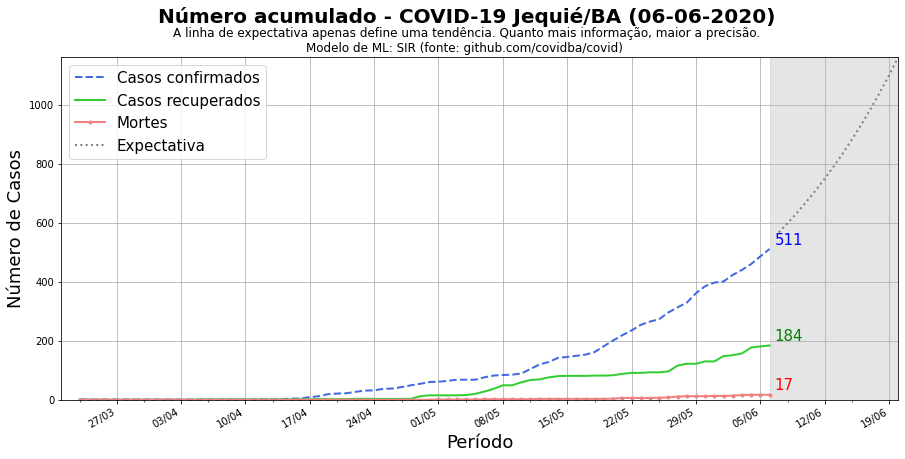

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
colors = ['royalblue','limegreen','lightcoral', 'gray']
ls = ['--', '-', '.-', ':', '.']

new_df = df.append(futherCases)
new_df['Expectativa'] = predictions

taxa_dict = {'data': new_df['data'], 'confirmados': new_df['Casos confirmados'], 'recuperados': new_df['Casos recuperados'],
             'mortes': new_df['Mortes'], 'expectativa': new_df['Expectativa']}

df30 = pd.DataFrame(taxa_dict)
df30.columns = ['Data', 'Casos confirmados', 'Casos recuperados', 'Mortes', 'Expectativa']
df30.set_index('Data', inplace=True)

df30.plot(ax=ax, color=colors, style=ls, lw=2)
fig.autofmt_xdate()
 
#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
 
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))
 
# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), lista_data.max().strftime("%Y-%m-%d"), 
           alpha=0.2, color='gray')
 
def adicionar_medida(texto, id, color='green'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], ymax=0.8)
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], new_df1['Mortes'].max()+10), rotation=90,
            xycoords='data', ha='center', fontsize=15, color=color,
            xytext=(-10, 0), textcoords='offset points')

# ADICIONAR MEDIDAS
def adicionar_medidas():
  for id, medida in enumerate(df['Medida restritiva']):
    # toque de recolher
    if not pd.isnull(medida):
      if medida == 0:
        adicionar_medida('Abertura comércio', id) 
      elif medida == 1:
        adicionar_medida('Fechamento comércio', id, color='purple') 
      elif medida > 1 and medida <= 24:
        if medida == 24:
          adicionar_medida('Saída do toque de recolher', id)
        else:
          adicionar_medida('Toque de recolher (%sh)' % int(medida), id, color='purple')      
      elif medida == 50:
        adicionar_medida('Entrada no lockdown', id, color='purple')
      elif medida == 51:
        adicionar_medida('Saída do lockdown', id)
      elif medida == 61:
        adicionar_medida('Fase 1 - abertura comércio', id, color='gray')
      elif medida == 62:
        adicionar_medida('Fase 2 - abertura comércio', id, color='gray')
      elif medida == 63:
        adicionar_medida('Fase 3 - abertura comércio', id, color='gray')
      elif medida == 64:
        adicionar_medida('Fase 4 - abertura comércio', id, color='gray')
      elif medida == 65:
        adicionar_medida('Fase 5 - abertura comércio', id, color='gray')
  
#adicionar_medidas()
 
# ADICIONAR VALORES  
adicionar_valores('Casos confirmados', 'b', x=5)
adicionar_valores('Casos recuperados', 'g', x=5)
adicionar_valores('Mortes', 'r', x=5)
 
ax.set_xlim([lista_data.min()-timedelta(days=2), lista_data.max()])
ax.set_ylim([0, new_df['Expectativa'].max()])
fig.suptitle("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, ultima_data_valida), fontsize=20, fontweight='bold')
ax.set_title("A linha de expectativa apenas define uma tendência. Quanto mais informação, maior a precisão.       \nModelo de ML: SIR (fonte: %s)        "  % url_fonte)
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/%s-todo.png' % cidade_file_name)

/content/gdrive/My Drive/model/main/modelos.py:156: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))
/content/gdrive/My Drive/model/main/modelos.py:686: RuntimeWarning: overflow encountered in exp
  h = 1.0/(1.0+ np.exp(-2.0*50*t))


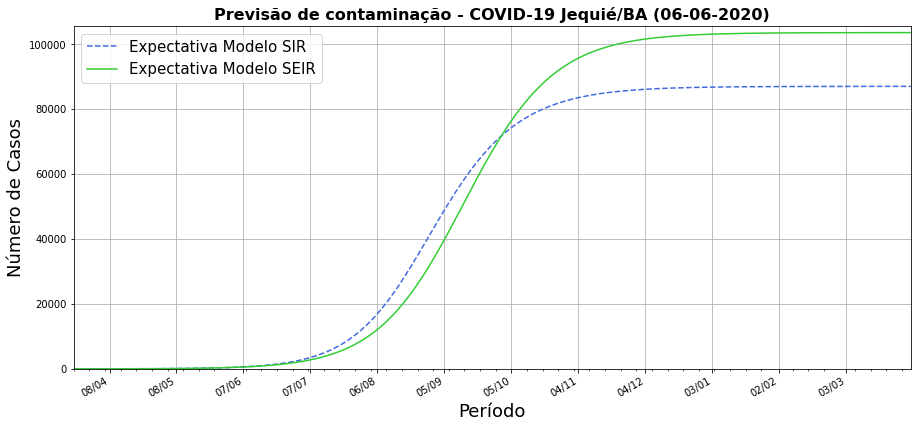

In [27]:
totalCases = pd.DataFrame.from_dict({"data":pd.date_range(start = df['data'].max()+timedelta(days=1) , end = df['data'].max()+timedelta(days=300))})
 
file1 = open('/content/gdrive/My Drive/model/%s-sir-06.dat' % cidade_file_name,'rb')
model_sir = pk.load( file1 )
file1.close()

file1 = open('/content/gdrive/My Drive/model/%s-seir-06.dat' % cidade_file_name,'rb')
model_seir = pk.load( file1 )
file1.close()

df_proj = pd.concat([df, totalCases])
predictions_sir = model_sir.predict(df_proj)
predictions_seir = model_seir.predict(df_proj)

fig, ax = plt.subplots(figsize=(15,7))
colors = ['royalblue','limegreen','lightcoral', 'gray', 'gray']
ls = ['--', '-', '.-', ':', '.']

projecao = df.append(totalCases)
projecao['Expectativa SIR'] = predictions_sir
projecao['Expectativa SEIR'] = predictions_seir

taxa_dict = {'data': projecao['data'], 'expectativa_sir': projecao['Expectativa SIR'], 'expectativa_seir': projecao['Expectativa SEIR']}

df30 = pd.DataFrame(taxa_dict)
df30.columns = ['Data', 'Expectativa Modelo SIR', 'Expectativa Modelo SEIR']
df30.set_index('Data', inplace=True)

df30.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()
 
#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
 
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15), loc=2)
 
def adicionar_medida(texto, id, color='green'):
  ax.axvline(linewidth=2, color=color, ls='--', x=lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], ymax=0.8)
  ax.annotate('%s' % texto, xy=(lista_data[(lista_data == pd.Timestamp(df['data'][id])).argmax()], new_df['Mortes'].max()+10), rotation=90,
            xycoords='data', ha='center', fontsize=15, color=color,
            xytext=(-10, 0), textcoords='offset points')

ax.set_ylim([0, projecao['Expectativa SEIR'].max()+2000])
ax.set_title("Previsão de contaminação - COVID-19 %s/BA (%s)" % (cidade, ultima_data_valida), fontsize=16, fontweight='bold')
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/jequie-tendencia-06-20.png')

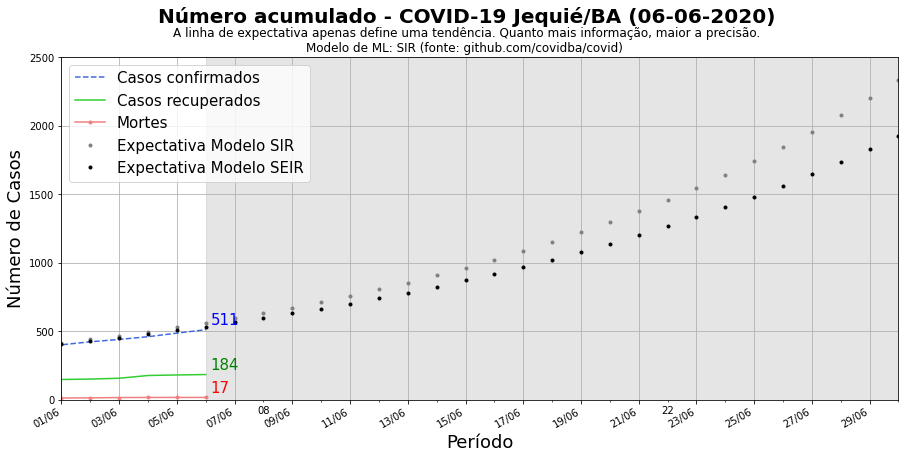

In [28]:
colors = ['royalblue','limegreen','lightcoral', 'gray', 'black']
ls = ['--', '-', '.-', '.', '.']

new_df = df.append(totalCases)
new_df['Expectativa Modelo SIR'] = predictions_sir
new_df['Expectativa Modelo SEIR'] = predictions_seir

new_dict = {'Data': new_df['data'], 
             'Casos confirmados': new_df['Casos confirmados'],
             'Casos recuperados': new_df['Casos recuperados'],
             'Mortes': new_df['Mortes'],
             'Expectativa Modelo SIR': new_df['Expectativa Modelo SIR'],
             'Expectativa Modelo SEIR': new_df['Expectativa Modelo SEIR'],
             }

df30 = pd.DataFrame(new_dict)
df30.columns = ['Data', 'Casos confirmados', 'Casos recuperados', 'Mortes', 'Expectativa Modelo SIR', 'Expectativa Modelo SEIR']
df30.set_index('Data', inplace=True)

fig, ax = plt.subplots(figsize=(15,7))
df30.plot(ax=ax, color=colors, style=ls)
fig.autofmt_xdate()
 
#set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(MO))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
 
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.set_xticks(ax.get_xticks()[::1])
ax.legend(prop=dict(size=15))
 
# pintar área de projeção
ax.axvspan(df['data'][ultimo_caso_valido_id].strftime("%Y-%m-%d"), pd.Timestamp("2020-06-30"), 
           alpha=0.2, color='gray')
#adicionar_medidas()
 
# ADICIONAR VALORES
adicionar_valores('Casos confirmados', 'b', x=5)
adicionar_valores('Casos recuperados', 'g', x=5)
adicionar_valores('Mortes', 'r', x=5)

ax.set_ylim([0, 2500])
#ax.set_xlim([lista_data.max() - timedelta(days=30), lista_data.max()])
ax.set_xlim([pd.Timestamp("2020-06-01"), pd.Timestamp("2020-06-30")])
fig.suptitle("Número acumulado - COVID-19 %s/BA (%s)" % (cidade, ultima_data_valida), fontsize=20, fontweight='bold')
ax.set_title("A linha de expectativa apenas define uma tendência. Quanto mais informação, maior a precisão.       \nModelo de ML: SIR (fonte: %s)        "  % url_fonte)
ax.set_ylabel('Número de Casos', fontsize=18)
ax.set_xlabel('Período', fontsize=18)
ax.grid(True)
plt.savefig('/content/gdrive/My Drive/model/jequie-30-dias.png')

# Situação por Bairro



Text(0, 0, 'Fonte: github.com/covidba/covid')

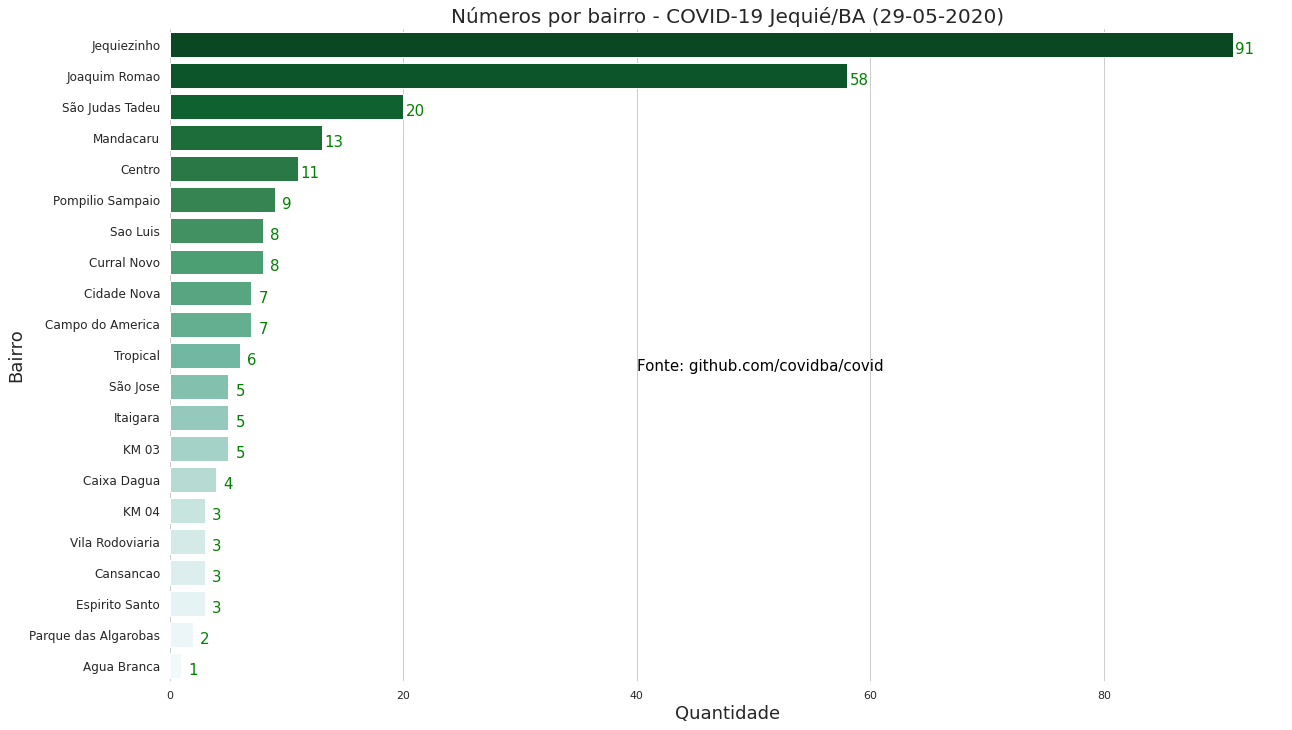

In [0]:
import seaborn as sns
sns.set(style="whitegrid")

url = 'https://raw.githubusercontent.com/covidba/covid/master/%s_bairro.csv' % cidade_file_name
df_bairro = pd.read_csv(url, usecols=['Bairro', 'Quantidade'])
df_bairro.head()

bairro = df_bairro['Bairro']
quantidade = df_bairro['Quantidade']

df_bairro = pd.DataFrame({'Bairro': bairro,
                   'Quantidade': quantidade})

fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(x='Quantidade', y='Bairro', data=df_bairro, ax=ax, palette="BuGn_r",  orient = 'h')
sns.despine(left=True, bottom=True)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)

for i, v in enumerate(quantidade):
    ax.annotate(int(v), xy=(v, i+0.3), xycoords='data', ha='center', fontsize=15, color='green',
              xytext=(12, 0), textcoords='offset points')
    

ax.set_title("Números por bairro - COVID-19 %s/BA (%s)" % (cidade, ultima_data_valida), fontsize=20)
ax.set_ylabel('Bairro', fontsize=18)
ax.set_xlabel('Quantidade', fontsize=18)

url_fonte = 'github.com/covidba/covid'
ax.annotate('Fonte: %s' % url_fonte, xy=(40, len(bairro)/2), 
          xycoords='data', ha='left', fontsize=15, color='black',
          xytext=(0, 0), textcoords='offset points')

# Situação por faixa etária



Text(0, 0, 'Fonte: github.com/covidba/covid')

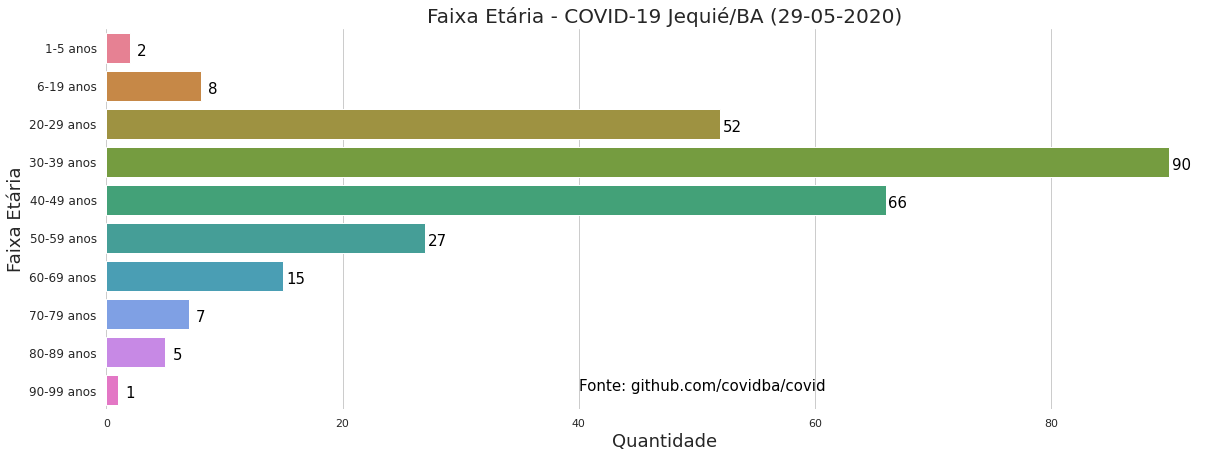

In [0]:
url = 'https://raw.githubusercontent.com/covidba/covid/master/%s_faixa_etaria.csv' % cidade_file_name
df_etaria = pd.read_csv(url, usecols=['Faixa Etaria', 'Quantidade'])
df_etaria.head()

faixa = df_etaria['Faixa Etaria']
quantidade = df_etaria['Quantidade']

df_etaria = pd.DataFrame({'Faixa Etaria': faixa,
                   'Quantidade': quantidade})

fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x='Quantidade', y='Faixa Etaria', data=df_etaria, ax=ax, palette="husl",  orient='h')
sns.despine(left=True, bottom=True)

for i, v in enumerate(quantidade):
    ax.annotate(int(v), xy=(v, i+0.2), xycoords='data', ha='center', fontsize=15, color='black',
              xytext=(12, 0), textcoords='offset points')
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12)


ax.set_title("Faixa Etária - COVID-19 %s/BA (%s)" % (cidade, ultima_data_valida), fontsize=20)
ax.set_ylabel('Faixa Etária', fontsize=18)
ax.set_xlabel('Quantidade', fontsize=18)

ax.annotate('Fonte: %s' % url_fonte, xy=(40, len(faixa)-1), 
          xycoords='data', ha='left', fontsize=15, color='black',
          xytext=(0, 0), textcoords='offset points')